In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.colors import LogNorm, Normalize

def load_sweep_data_pkl():
    """Load all pickle files and combine the data"""
    data_files = glob.glob('results_ttot_*.pkl')
    all_data = []
    
    for file in data_files:
        with open(file, 'rb') as f:
            data = pickle.load(f)
            t_tot = data['t_tot']
            w_d_arr = data['w_d_arr']
            amp_arr = data['amp_arr']
            ave_transfer_prob_list = data['ave_transfer_prob_list']
            # Calculate average transfer probability for each parameter combination
            for idx, ave_transfer_prob in enumerate(ave_transfer_prob_list):
                w_d_idx = idx // len(amp_arr)
                amp_idx = idx % len(amp_arr)

                all_data.append({
                    't_tot': t_tot,
                    'w_d': w_d_arr[w_d_idx],
                    'amp': amp_arr[amp_idx],
                    'transfer_prob': ave_transfer_prob
                })
    
    return all_data

import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.colors import LogNorm, Normalize

def load_sweep_data():
    """Load all npz files from the sweep and combine them into a DataFrame"""
    # Find all npz files from the sweep
    sweep_files = glob.glob("sweep_start_idx_*_end_idx_*_*lvls.npz")
    
    all_data = []
    
    for file in sweep_files:
        # Extract n_lvls from filename
        n_lvls = int(file.split('_')[-1].split('lvls.npz')[0])
        
        # Load the npz file
        data = np.load(file)
        parameters = data['parameters']  # Shape: (N, 3) for [t_tot, w_d, amp]
        transfer_probs = data['transfer_probs']  # Shape: (N,)
        
        # Create records for each parameter combination
        for params, prob in zip(parameters, transfer_probs):
            t_tot, w_d, amp = params
            all_data.append({
                't_tot': t_tot,
                'w_d': w_d,
                'amp': amp,
                'transfer_prob': prob,
                'n_lvls': n_lvls
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    
    # Sort by n_lvls to make sure we're consistent
    df = df.sort_values(['n_lvls', 't_tot', 'w_d', 'amp'])
    
    return df



def create_interactive_plot():
    # Load data
    data = load_sweep_data_pkl()
    
    # Get unique values for each parameter
    t_tot_values = sorted(list(set(d['t_tot'] for d in data)))
    w_d_values = sorted(list(set(d['w_d'] for d in data)))
    amp_values = sorted(list(set(d['amp'] for d in data)))
    
    # Create widgets (existing dropdowns)
    x_axis_dropdown = widgets.Dropdown(
        options=['t_tot', 'w_d', 'amp'],
        description='X-axis:',
        value='w_d'
    )

    y_axis_dropdown = widgets.Dropdown(
        options=['t_tot', 'w_d', 'amp'],
        description='Y-axis:',
        value='amp'
    )

    color_var_dropdown = widgets.Dropdown(
        options=['t_tot', 'w_d', 'amp', 'transfer_prob'],
        description='Color by:',
        value='transfer_prob'
    )

    # Add parameter sliders (existing)
    t_tot_slider = widgets.FloatSlider(
        value=t_tot_values[0],
        min=min(t_tot_values),
        max=max(t_tot_values),
        step=t_tot_values[1]-t_tot_values[0] if len(t_tot_values)>1 else 1,
        description='t_tot:',
        continuous_update=False
    )
    
    w_d_slider = widgets.FloatSlider(
        value=w_d_values[0],
        min=min(w_d_values),
        max=max(w_d_values),
        step=w_d_values[1]-w_d_values[0] if len(w_d_values)>1 else 1,
        description='w_d:',
        continuous_update=False
    )
    
    amp_slider = widgets.FloatSlider(
        value=amp_values[0],
        min=min(amp_values),
        max=max(amp_values),
        step=amp_values[1]-amp_values[0] if len(amp_values)>1 else 1,
        description='amp:',
        continuous_update=False
    )

    # Add color range sliders with log scale
    color_min_slider = widgets.FloatLogSlider(
        value=1e-7,
        min=-7,  # 1e-7
        max=0,   # 1e0
        step=0.1,
        description='Color min:',
        continuous_update=False
    )
    
    color_max_slider = widgets.FloatLogSlider(
        value=1,
        min=-7,  # 1e-7
        max=0,   # 1e0
        step=0.1,
        description='Color max:',
        continuous_update=False
    )

    colormap_dropdown = widgets.Dropdown(
        options=['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'rainbow'],
        description='Colormap:',
        value='viridis'
    )

    log_scale = widgets.Checkbox(
        value=True,
        description='Log scale color'
    )

    def plot_data(change=None):
        clear_output(wait=True)
        
        # Display widgets
        display(widgets.VBox([
            widgets.HBox([x_axis_dropdown, y_axis_dropdown, color_var_dropdown]),
            widgets.HBox([t_tot_slider, w_d_slider, amp_slider]),
            widgets.HBox([color_min_slider, color_max_slider]),
            widgets.HBox([colormap_dropdown, log_scale])
        ]))
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Filter data (existing code)
        def find_nearest(array, value):
            return min(array, key=lambda x: abs(x - value))
        
        t_tot_slice = find_nearest(t_tot_values, t_tot_slider.value)
        w_d_slice = find_nearest(w_d_values, w_d_slider.value)
        amp_slice = find_nearest(amp_values, amp_slider.value)
        
        filter_dict = {
            't_tot': t_tot_slice,
            'w_d': w_d_slice,
            'amp': amp_slice
        }
        del filter_dict[x_axis_dropdown.value]
        del filter_dict[y_axis_dropdown.value]
        
        filtered_data = [d for d in data if all(abs(d[k] - v) < 1e-10 for k, v in filter_dict.items())]
        
        if not filtered_data:
            plt.text(0.5, 0.5, 'No data points match the current slice', 
                    ha='center', va='center')
            plt.show()
            return
        
        x_values = [d[x_axis_dropdown.value] for d in filtered_data]
        y_values = [d[y_axis_dropdown.value] for d in filtered_data]
        color_values = [d[color_var_dropdown.value] for d in filtered_data]
        
        # Create scatter plot with controlled color range
        if log_scale.value:
            norm = LogNorm(vmin=color_min_slider.value, 
                         vmax=color_max_slider.value)
        else:
            norm = Normalize(vmin=color_min_slider.value, 
                           vmax=color_max_slider.value)
            
        scatter = ax.scatter(x_values, y_values,
                           c=color_values,
                           cmap=colormap_dropdown.value,
                           norm=norm,
                           alpha=0.6)
        
        # Configure grid
        ax.grid(True, which='major', linewidth=0.8)
        ax.grid(True, which='minor', linestyle='--', linewidth=0.3, alpha=0.5)
        ax.minorticks_on()
        
        ax.set_xlabel(x_axis_dropdown.value)
        ax.set_ylabel(y_axis_dropdown.value)
        
        # Add colorbar
        plt.colorbar(scatter, 
                    label=color_var_dropdown.value)
        
        # Add title showing the fixed parameter values
        title_parts = []
        for k, v in filter_dict.items():
            title_parts.append(f"{k}={v:.3f}")
        plt.title(", ".join(title_parts))
        
        plt.tight_layout()
        plt.show()

    # Connect widgets to the plot function
    for widget in [x_axis_dropdown, y_axis_dropdown, color_var_dropdown,
                  t_tot_slider, w_d_slider, amp_slider, 
                  color_min_slider, color_max_slider,
                  colormap_dropdown, log_scale]:
        widget.observe(plot_data, 'value')

    # Initial plot
    plot_data()


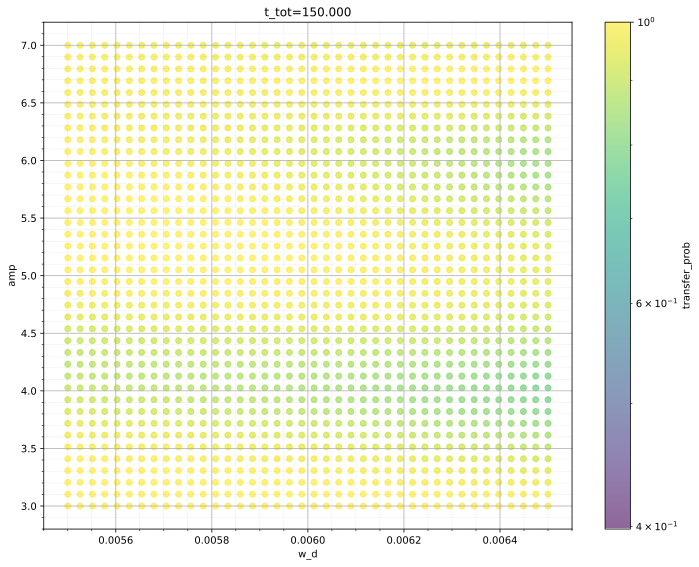

In [95]:
create_interactive_plot()

In [63]:
import qutip
from CoupledQuantumSystems.drive import *
from scipy.optimize import minimize
from CoupledQuantumSystems.IFQ import gfIFQ
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
import matplotlib.pyplot as plt
EJ = 3
EJoverEC = 6
EJoverEL = 25
EC = EJ / EJoverEC
EL = EJ / EJoverEL
n_lvls = 50
n_lvls_exp = 50
qbt = gfIFQ(EJ = EJ,EC = EC, EL = EL, flux = 0,truncated_dim=n_lvls)
e_ops = [qutip.basis(qbt.truncated_dim, i)*qutip.basis(qbt.truncated_dim, i).dag() for i in range(n_lvls_exp)]


def get_e_pop_j(state, j):
    return qutip.expect(qutip.ket2dm(qutip.basis(qbt.truncated_dim,j)), state)

def do_experiment(amp, w_d, t_tot):
    tlist = np.linspace(0, t_tot, 51)

    results = qbt.run_qutip_mesolve_parrallel(
                [qutip.basis(qbt.truncated_dim, 1), qutip.basis(qbt.truncated_dim, 2)],
                [tlist],
                drive_terms=[[
                            DriveTerm(
                                driven_op=qutip.Qobj(
                                    qbt.fluxonium.n_operator(energy_esys=True)),
                                pulse_shape_func=sin_squared_pulse_with_modulation,
                                pulse_id='pi',
                                pulse_shape_args={
                                    "w_d": w_d,    # No extra 2pi factor
                                    "amp": amp,    # No extra 2pi factor
                                    "t_duration": t_tot,
                                },
                            )
                        ]],
                c_ops=None,
                e_ops=[e_ops],
    )
    one_minus_pop2 = abs(1 - results[0][0].expect[2][-1])
    one_minus_pop1 = abs(1 - results[0][1].expect[1][-1])
    ave_transfer_prob = (one_minus_pop2 + one_minus_pop1) / 2
    print(f"{one_minus_pop1}, {one_minus_pop2}, {ave_transfer_prob}")

    fig, axes = plt.subplots(1,2,figsize=(10,5))
    for exp_idx in range(len(e_ops)):
        axes[0].plot(tlist, results[0][0].expect[exp_idx],label= f"|{exp_idx}>")
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-5,1e1)

    for exp_idx in range(len(e_ops)):
        axes[1].plot(tlist, results[0][1].expect[exp_idx],label= f"|{exp_idx}>")
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-5,1e1)
    plt.show()

0.06105369102558944, 0.061053696829179604, 0.06105369392738452


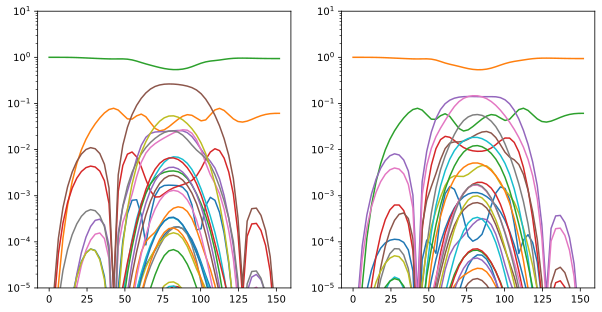

In [97]:
do_experiment(3.56, 0.0059, 152)

In [79]:
# Load the data
df = load_sweep_data()

In [80]:
df.head(20)

,t_tot,w_d,amp,transfer_prob,n_lvls
0,100.0,0.002252,0.000000,1.000000,20
1,100.0,0.002252,0.025126,0.999315,20
2,100.0,0.002252,0.050251,0.997267,20
3,100.0,0.002252,0.075377,0.993873,20
4,100.0,0.002252,0.100503,0.989161,20
5,100.0,0.002252,0.125628,0.983172,20
6,100.0,0.002252,0.150754,0.975955,20
7,100.0,0.002252,0.175879,0.967571,20
8,100.0,0.002252,0.000000,1.000000,23
9,100.0,0.002252,0.025126,0.999315,23


0.9938729271452191, 0.9938729272962806, 0.9938729272207498


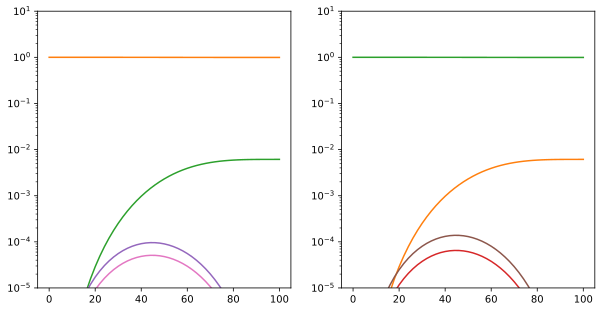

In [78]:
do_experiment(0.075377,0.002252, 100.0)